# Supervised Machine Learning Model

In this chapter we are presenting logistic regression and support vector machine models to see to what degree we can associate given tweet with it being posted by a party from opposition or proposition.

## 1. Libraries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertModel
import torch
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
import random

seed = 421
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## 2. Reading data

If you have word embeddings already in your df (from notebook 050) - skip this part. If not - load your df and uncomment those 2 chunks below

In [5]:
'''
df_filtered = pd.read_parquet('/Users/mateuszpliszka/Documents/GitHub/Twitter4/bez nazwy/data/03.cleaned/df_bert_values_GIT.parquet')
df_filtered['opposition_proposition'] = df_filtered['party'].apply(lambda x: 1 if x in ['Konfederacja', 'PIS'] else 0)
df_filtered = df_filtered[df_filtered['text_clean_en'].notna()]

X = df_filtered['text_clean_en']
y = df_filtered['opposition_proposition']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
'''

## 3. Creating word embeddings

In [7]:
'''
print("TF-IDF")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("SentenceTransformer")
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
df_filtered['encode_transforemers'] = df_filtered['text_clean_en_demojized'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())
X_train_st = np.array(df_filtered.loc[X_train.index, 'encode_transforemers'].tolist())
X_test_st = np.array(df_filtered.loc[X_test.index, 'encode_transforemers'].tolist())

print("CLS_BERT")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
def get_cls_sentence(sentence):
    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, max_length=512)])
    with torch.no_grad():
        outputs = model(input_ids)
        cls_embedding = outputs[0][:, 0, :]
    return cls_embedding.flatten()

df_filtered['cls_bert'] = df_filtered['text_clean_en_demojized'].apply(lambda sentence: get_cls_sentence(sentence))
X_train_cls_bert = np.array(df_filtered.loc[X_train.index, 'cls_bert'].tolist())
X_test_cls_bert = np.array(df_filtered.loc[X_test.index, 'cls_bert'].tolist())
'''


'\nprint("TF-IDF")\ntfidf_vectorizer = TfidfVectorizer(max_features=5000)\nX_train_tfidf = tfidf_vectorizer.fit_transform(X_train)\nX_test_tfidf = tfidf_vectorizer.transform(X_test)\n\nprint("SentenceTransformer")\nmodel = SentenceTransformer(\'paraphrase-MiniLM-L6-v2\')\ndf_filtered[\'encode_transforemers\'] = df_filtered[\'text_clean_en_demojized\'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())\nX_train_st = np.array(df_filtered.loc[X_train.index, \'encode_transforemers\'].tolist())\nX_test_st = np.array(df_filtered.loc[X_test.index, \'encode_transforemers\'].tolist())\n\nprint("CLS_BERT")\ntokenizer = BertTokenizer.from_pretrained(\'bert-base-uncased\')\nmodel = BertModel.from_pretrained(\'bert-base-uncased\')\ndef get_cls_sentence(sentence):\n    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, max_length=512)])\n    with torch.no_grad():\n        outputs = model(input_ids)\n        cls_embedding = outputs[0][:, 0, :]\n    retu

 ## 3.1 Loading existing df with word embeddings

In [3]:
df_filtered = pd.read_pickle('/Users/mateuszpliszka/Documents/GitHub/Twitter4/bez nazwy/data/03.cleaned/df_vectorizations.pkl')

In [4]:
X_text = df_filtered['text_clean_en']
df_filtered['opposition_proposition'] = df_filtered.apply(
    lambda row: (
        1 if row['created_at'] < pd.Timestamp('2023-10-15 00:00:00+00:00') and row['party'] == 'PIS'
        else 0 if row['created_at'] < pd.Timestamp('2023-10-15 00:00:00+00:00')
        else 0 if row['party'] in ['PIS', 'Konfederacja']
        else 1
    ),
    axis=1
)
y = df_filtered['opposition_proposition'].astype(int)

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

In [5]:
train_idx, test_idx = train_test_split(df_filtered.index, test_size=0.2, stratify=y, random_state=42)

# TF-IDF
X_train_tfidf = X_tfidf[train_idx]
X_test_tfidf = X_tfidf[test_idx]

# SentenceTransformer
X_transformers = np.vstack(df_filtered['encode_transforemers'].values)
X_train_st = X_transformers[train_idx]
X_test_st = X_transformers[test_idx]

# BERT CLS
X_cls_bert = np.vstack(df_filtered['cls_bert'].values)
X_train_cls = X_cls_bert[train_idx]
X_test_cls = X_cls_bert[test_idx]

# Target
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

## 4. Logistic regression model
Below, there are logistic regression models basing on the word embeddings

Classification Report for TF-IDF:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81      6269
           1       0.68      0.43      0.53      3398

    accuracy                           0.73      9667
   macro avg       0.71      0.66      0.67      9667
weighted avg       0.72      0.73      0.71      9667

AUC for TF-IDF: 0.76


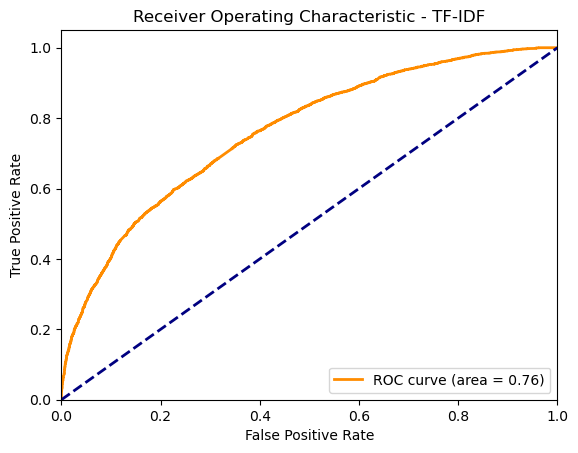

Classification Report for Sentence Transformers:
              precision    recall  f1-score   support

           0       0.71      0.88      0.78      6269
           1       0.60      0.33      0.42      3398

    accuracy                           0.69      9667
   macro avg       0.65      0.60      0.60      9667
weighted avg       0.67      0.69      0.66      9667

AUC for Sentence Transformers: 0.69


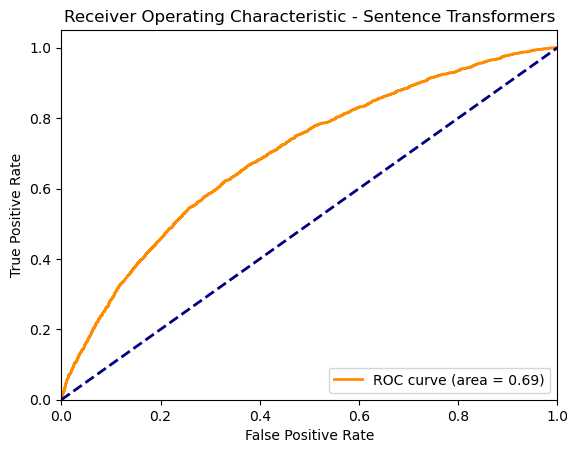

Classification Report for CLS BERT:
              precision    recall  f1-score   support

           0       0.72      0.86      0.78      6269
           1       0.59      0.37      0.46      3398

    accuracy                           0.69      9667
   macro avg       0.65      0.62      0.62      9667
weighted avg       0.67      0.69      0.67      9667

AUC for CLS BERT: 0.71


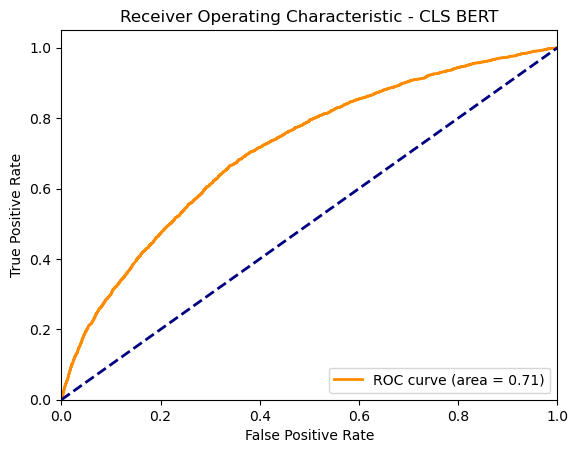

In [7]:
def plot_roc_curve(y_test, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def train_evaluate_and_plot(X_train, X_test, y_train, y_test, model_name):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    print(f"AUC for {model_name}: {roc_auc_score(y_test, y_pred_proba):.2f}")
    plot_roc_curve(y_test, y_pred_proba, model_name)

# TF-IDF
train_evaluate_and_plot(X_train_tfidf, X_test_tfidf, y_train, y_test, "TF-IDF")

# Sentence Transformers
train_evaluate_and_plot(X_train_st, X_test_st, y_train, y_test, "Sentence Transformers")

# CLS BERT
train_evaluate_and_plot(X_train_cls, X_test_cls, y_train, y_test, "CLS BERT")

We can observe that the performance of Logistic Regression does not vary significantly across different embedding methods. While the best performance was achieved using the TF-IDF embedding method, it is worth noting that its advantage over the other methods is minimal.

## 5. Support vector machines models

Below, there are 3 support vector machine models based on the word embeddings from chapter 5. Models have been tuned and cross-validated. 


--- Fast Linear SVM: TF-IDF (Linear) ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.73      0.91      0.81      6269
           1       0.69      0.37      0.48      3398

    accuracy                           0.72      9667
   macro avg       0.71      0.64      0.64      9667
weighted avg       0.71      0.72      0.69      9667

AUC: 0.76


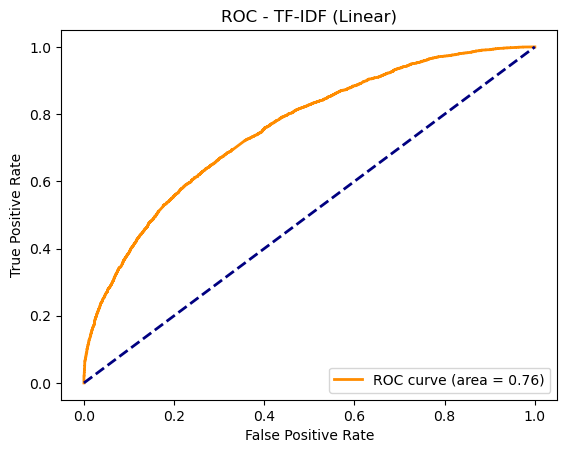


--- Fast Linear SVM: Sentence Transformers (Linear) ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.70      0.90      0.79      6269
           1       0.61      0.28      0.38      3398

    accuracy                           0.68      9667
   macro avg       0.65      0.59      0.58      9667
weighted avg       0.67      0.68      0.65      9667

AUC: 0.69


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


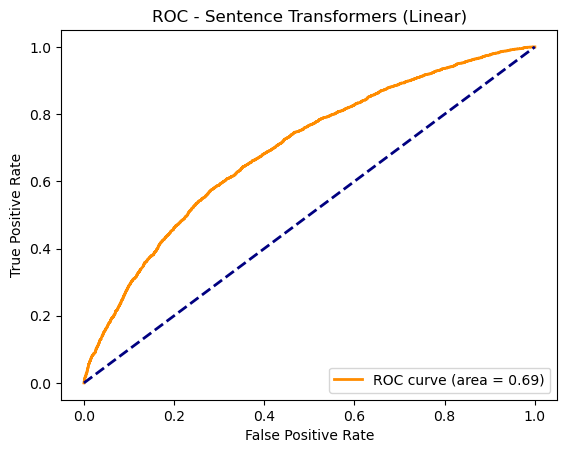


--- Fast Linear SVM: CLS BERT (Linear) ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.70      0.91      0.79      6269
           1       0.63      0.30      0.40      3398

    accuracy                           0.69      9667
   macro avg       0.67      0.60      0.60      9667
weighted avg       0.68      0.69      0.66      9667

AUC: 0.71


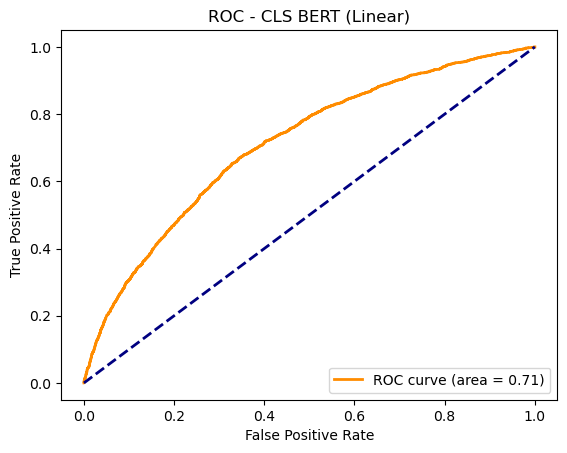

In [8]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from scipy.stats import uniform

def plot_roc_curve(y_test, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def fast_linear_svm(X_train, X_test, y_train, y_test, model_name):
    print(f"\n--- Fast Linear SVM: {model_name} ---")
    svc = LinearSVC(C=1, max_iter=2000)
    calibrated = CalibratedClassifierCV(svc, cv=2)
    calibrated.fit(X_train, y_train)
    y_pred = calibrated.predict(X_test)
    y_pred_proba = calibrated.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred))
    print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.2f}")
    plot_roc_curve(y_test, y_pred_proba, model_name)

def fast_rbf_svm(X_train, X_test, y_train, y_test, model_name):
    print(f"\n--- Fast RBF SVM: {model_name} ---")
    param_dist = {
        'C': uniform(0.1, 10),
        'gamma': uniform(0.001, 0.1),
        'kernel': ['rbf']
    }
    svc = SVC(probability=True)
    search = RandomizedSearchCV(svc, param_distributions=param_dist, n_iter=5, cv=2, n_jobs=-1, verbose=1)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    print(f"Best params: {search.best_params_}")
    print(classification_report(y_test, y_pred))
    print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.2f}")
    plot_roc_curve(y_test, y_pred_proba, model_name)

# ---- Run SVMs ----
fast_linear_svm(X_train_tfidf, X_test_tfidf, y_train, y_test, "TF-IDF (Linear)")
fast_linear_svm(X_train_st, X_test_st, y_train, y_test, "Sentence Transformers (Linear)")
fast_linear_svm(X_train_cls, X_test_cls, y_train, y_test, "CLS BERT (Linear)")


We observe that SVM outperforms Logistic Regression, particularly in effectively capturing the minority opposition class, which has fewer samples than the preposition class. This capability contributes to its overall better performance, achieving an F1-score of 0.81 and an AUC of 0.85.

## 6. Conclusions 

Conclustions for the year after election (calculated before):
1. Logistic Regression shows consistent performance across different embedding methods, with minimal variation. The TF-IDF embedding method achieved the best performance. However, its advantage in performance over the other methods is negligible. The main advantage of TF-IDF is the time required to generate embeddings, which is almost immediate compared to the other methods.

2. SVM demonstrates better performance compared to Logistic Regression, particularly in handling the minority opposition class, which has fewer samples than the proposition class. This capability contributes to its overall better performance, achieving an F1-score of 0.81 and an AUC of 0.89.

We need to differentiate 3 models:
 - before the election
 - after the election 
 - all together (already presented)
 - run a more avanced SVM 